Dataset: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

Glove: https://www.kaggle.com/takuok/glove840b300dtxt

# Sentiment classification on E-commerce dataset
----
----

## Workflow
-----

### 1. About Data, Machine Learning Formulation and EDA

### 2. Preprocessing

### 3. Feature Engineering

### 4. Modeling and hypertuining

### 5. Result and deploying prediction pipeline


### Explanation . . .. 

![](http://)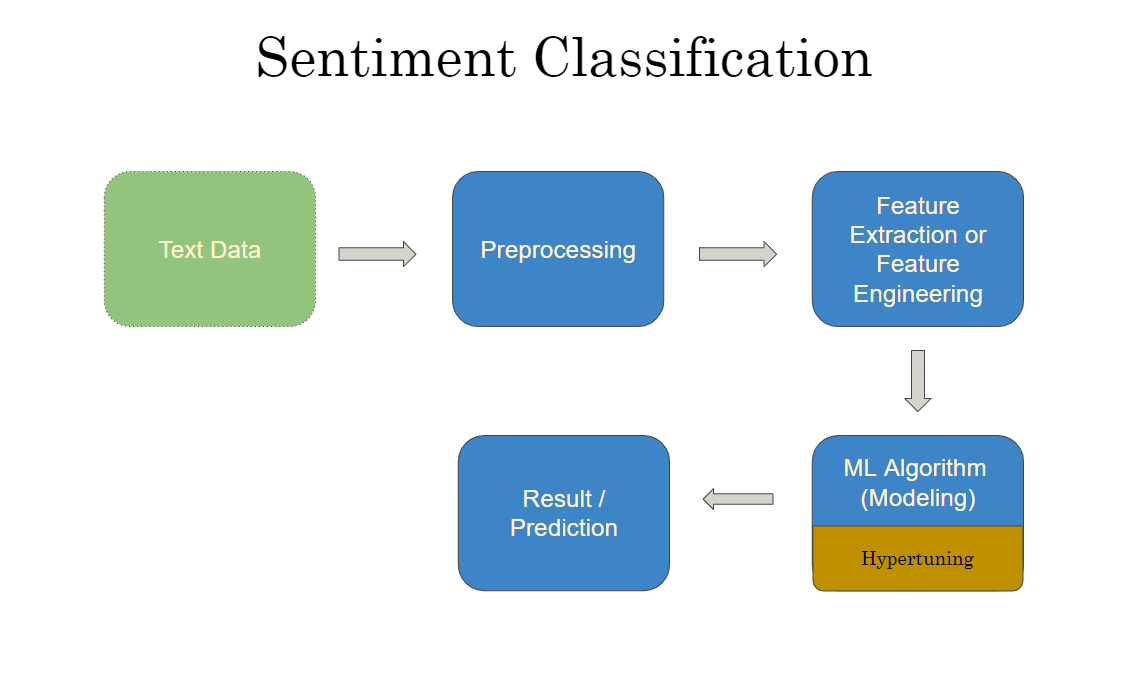

----

###  Importing llibraries

In [ ]:
# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
        
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split # for spliting dataset
from sklearn.feature_extraction.text import CountVectorizer # bow-->1gram and 2 gram
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from gensim.models import Word2Vec  # w2v
from gensim.models import KeyedVectors # to understanding w2v using google pre trained model
from sklearn.metrics import accuracy_score # to check the accuracy of model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # k-fold cv
from sklearn.metrics import classification_report
import pickle
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from lime import lime_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from imblearn.over_sampling import SMOTE


# 1. About Data, Machine Learning Formulation and EDA

## 1.1 About Dataset


#### Dataset Source: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews


### Context:
Welcome. This is a Women’s Clothing E-Commerce dataset revolving around the reviews written by customers. Its nine supportive features offer a great environment to parse out the text through its multiple dimensions. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with “retailer”.


### Content:

#### This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

**Clothing ID:** Integer Categorical variable that refers to the specific piece being reviewed.

**Age:** Positive Integer variable of the reviewers age.

**Title:** String variable for the title of the review.

**Review Text:** String variable for the review body.

**Rating:** Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

**Recommended IND:** Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

**Positive Feedback Count:** Positive Integer documenting the number of other customers who found this review positive.

**Division Name:** Categorical name of the product high level division.

**Department Name:** Categorical name of the product department name.

**Class Name:** Categorical name of the product class name.


### Note: Iam only using *'Review Text'* as features and *'Rating'* as class labels and converting into binary classification problem.
#### {1: positive sentiment, 0: Negative sentiment}

## 1.1.1. Loading the dataset and dataset Overview


In [ ]:
# Loading CSV file
data = pd.read_csv("../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv",index_col=0)

# Using only 'Review text' and 'Rating' and descarding other columns
data = data[['Review Text','Rating']] 

# Converting into binary classification problem
data = data[data['Rating']!=3]
data['Rating'] = data['Rating'].apply(lambda x: 0 if x<3 else 1)

# Shape of dataset
print("Shape of the dataset:",data.shape)

# Overview of data
print("\nOverview of data: ")
data.info

## 1.2. Machine Learning Formulation

#### Its a simple Binary Classification 
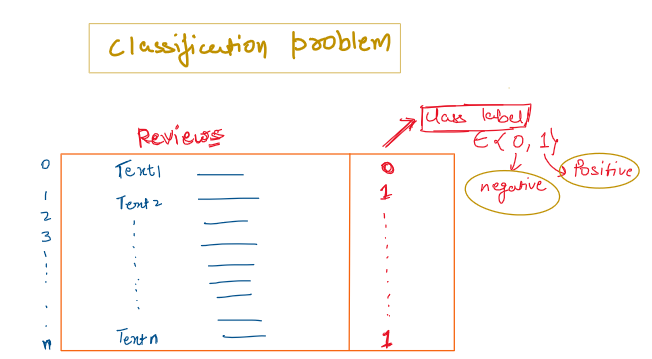

### 1.2.1. Evaluation Metric

#### 1. Logloss ass primary metric. (want to penalise based on probability score of each class and also for better interpretability of model for both of the class)
#### 2. Classification Report as secondary metric (include accuracy, precision, recall, f1_score)  

## 1.3. Overview EDA

* Dataset Overview
* Distribution of classlabel
* Missing Values and Duplicate values

### 1.3.1. Pandas Profiling

Learning Resource for pandas profiling:

1. https://towardsdatascience.com/a-better-eda-with-pandas-profiling-e842a00e1136

2. https://github.com/pandas-profiling/pandas-profiling


In [ ]:
# Pandas Profiling : Really good library to get the overview EDA.
profile = ProfileReport(data, title='Pandas Profiling Report',minimal=False, html={'style':{'full_width':True}})
profile.to_widgets()

### 1.3.2 Missing Values and Duplicate values

In [ ]:
# Finding missing values
print(f"Number of Missing values: \n{data.isnull().sum()}\n")

print(f"number of duplicated reviews: {sum(data[data['Review Text'].notnull()].duplicated(['Review Text'],keep='first'))}")

In [ ]:
# Duplicate Review text example
data[data['Review Text'].notnull()][data[data['Review Text'].notnull()].duplicated(['Review Text'],keep=False)]

### 1.3.2 Distribution of class labels(sentiments)

In [ ]:
# Removing datapoints having missing values and duplicate Review text
data_after_drop = data[data['Review Text'].notnull()]
data_after_drop = data_after_drop.drop_duplicates(['Review Text'],keep='first')

print(f"percentage of data remaing after dopping missing values and duplicate reviews: { round((data_after_drop.shape[0]/data.shape[0])*100,3)} %")

In [ ]:
# Classlabel value counts

temp  = data_after_drop['Rating'].value_counts()
print(pd.DataFrame({'Class label(sentiment)':temp.index, "values_counts":temp.values,"distribution percentage":temp.values/sum(temp.values) }))

# Ploting distribution of classlabel
sn.countplot(data_after_drop['Rating'])
plt.show()

Observation:
* Class labels are high imbalance. Using accuracy as metric is really not a good idea to check the performance of model.

## 2. Preprocessing

1. tokenize and lowering words
2. Decontraction (mis spelled words)
3. Cleaning(html tags remove, punctuation remove etc)
4. stopwords remove
5. lemmatization or stemming
5. Unnecessary words remove(word_len<3)


In [ ]:
# Preprocessing Functions
# credit : https://www.kaggle.com/urvishp80/quest-encoding-ensemble

#======================================================================================================================================
# Return the number of links and text without html tags 
# Also return the counts of 'number of lines'  and remove it
def strip_html(text):
    """ Return theclean text (without html tags) """
    
    # Removing HTML tags
    text = re.sub(r'http[s]?://\S+'," ",text)
    
    # finding number of lines using regex and counting it and remove it
    text = re.sub(r'\n', " ",text)
    
    return  text


#======================================================================================================================================
mispell_dict = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","couldnt" : "could not","didn't" : "did not","doesn't" : "does not",
                "doesnt" : "does not","don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","havent" : "have not",
                "he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "i would","i'd" : "i had","i'll" : "i will","i'm" : "i am",
                "isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not",
                "mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
                "shouldnt" : "should not","that's" : "that is","thats" : "that is","there's" : "there is","theres" : "there is","they'd" : "they would",
                "they'll" : "they will","they're" : "they are","theyre":  "they are","they've" : "they have","we'd" : "we would","we're" : "we are",
                "weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have",
                "where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have",
                "won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have",
                "'re": " are","wasn't": "was not","we'll":" will","didn't": "did not","tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    
    text = text.lower()
    
    
    """De-Concatenation of words and correction of misspelled words"""
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


#======================================================================================================================================
# removing non_alpha_numeric character and removing all the special character words
def non_alpha_numeric_remove(text):  
    
    # removing all non alpha char 
    text = re.sub(r"[^A-Za-z]", " ",text)
    
    return text 

#======================================================================================================================================

# function to remove all the stopwords and words having lengths less than 3
def remove_stop_words_and_punc(text) :
    
    """ 
    Remove all the stopwords 
    
    """
    # removing the words from the stop words list: 'no', 'nor', 'not'
    stops = set(stopwords.words("english"))
    stops.remove('no')
    stops.remove('nor')
    stops.remove('not')
    
    clean_text = []
    for word in text.split():
        if word not in stops and len(word)>3:        
            clean_text.append(word)
        
    clean_text = " ".join(clean_text)
    
    return(clean_text)

#======================================================================================================================================
# function for stemming of words in text
def stem(text):
    stemmer = PorterStemmer()
    result = " ".join([ stemmer.stem(word) for word in text.split(" ")])
    return result

#======================================================================================================================================
#======================================================================================================================================
# Final text cleaning funtion  
def clean_text(text):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text
    
    """
    
    # remove html tags
    clean_text = strip_html(text)  
    
    # de-concatenation of words
    clean_text = replace_typical_misspell(clean_text)
     
    # Count the number of non alpha numeric character and remove it
    clean_text = non_alpha_numeric_remove(clean_text)
    
    # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
    clean_text = remove_stop_words_and_punc(clean_text)
    
    # stemming ( use only for BOW or TFIDF represention. Not effective for word embedding like w2v or glove)
    clean_text = stem(clean_text)

    return clean_text

In [ ]:
# Preprocessing 
cleaned_review_text = data_after_drop['Review Text'].apply(lambda x: clean_text(x))

# Sample
i=15
print(f"\nBefore Preprocessing\n{'='*20}")
print(data_after_drop['Review Text'].iloc[i])

print(f"\nAfter Preprocessing\n{'='*20}")
print(cleaned_review_text.iloc[i])

### 2.1. Distribution  number of word in text (before and after preprocessing)

In [ ]:
# Calculating the length of text before and after preprocessing
len_after_cleaning = cleaned_review_text.apply(lambda x : len(x.split()))
len_before_cleaning = data_after_drop['Review Text'].apply(lambda x : len(x.split()))
    
# ploting
plt.figure(figsize=(9,6))
sn.distplot(len_before_cleaning, label=f'Review text before cleaning')
sn.distplot(len_after_cleaning, label=f'Review text after cleaning')
plt.title(f" Distribution of number of words of Review text before v/s after preprocessing\n",fontsize=15)
plt.ylabel("distribtion")
plt.xlabel(f"number of words in Review text")
plt.legend()
plt.grid()
plt.show()

## 3. Feature Engineering or Feature Extraction

#### 3.1. Bag of Words (countvectoriser)
#### 3.2. TF-IDF
#### 3.3. Word2Vec CBOW on own corpus
#### 3.4. Word2Vec Skipgram on own corpus
#### 3.5. Word2Vec pretrained 
#### 3.6. Doc2Vec trained on own corpus 
#### 3.7. Doc2Vec pretrained 

### Train Test Split

In [ ]:
# train test split

X = data_after_drop['Review Text']
y = data_after_drop['Rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

#### Preprocessing for BOW and TFIDF

In [ ]:
# Preprocessing for BOW and TFIDF
X_train_clean_text = X_train.apply(lambda x: clean_text(x))
X_val_clean_text = X_val.apply(lambda x: clean_text(x))

### 3.1. Bag of Words (BOW)


#### 3.1.1. BOW - unigram 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_bow_unigram = count_vect.fit_transform(X_train_clean_text)
x_val_bow_unigram = count_vect.transform(X_val_clean_text)

print(f"shape of features after BOW Feture extraction: {x_train_bow_unigram.shape}")

# Sparsity of BOW-unigram
sparsiry_bow = (len(x_train_bow_unigram.toarray().nonzero()[0]) / len(np.nonzero(x_train_bow_unigram.toarray()==0)[0]))*100
print(f"Sparsity of BOW: {round(sparsiry_bow,5)}%")

In [ ]:
# BOW feature representaiona
bow_unigram_feature_representation = pd.DataFrame(data = x_train_bow_unigram.toarray(), columns = count_vect.get_feature_names())
bow_unigram_feature_representation.head()

#### 3.1.2. BOW - bigram

### 3.2. TF-IDF


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_tfidf_unigram = tfidf_vect.fit_transform(X_train_clean_text)
x_val_tfidf_unigram = tfidf_vect.transform(X_val_clean_text)

print(f"shape of features after BOW Feture extraction: {x_train_tfidf_unigram.shape}")

# Sparsity of TFIDF-unigram
sparsiry_tfidf = (len(x_train_tfidf_unigram.toarray().nonzero()[0]) / len(np.nonzero(x_train_tfidf_unigram.toarray()==0)[0]))*100
print(f"Sparsity of TFIDF: {round(sparsiry_tfidf,5)}%")

In [ ]:
# Tf-IDF feature representaion
tfidf_unigram_feature_representation = pd.DataFrame(data = x_train_tfidf_unigram.toarray(), columns = tfidf_vect.get_feature_names())
tfidf_unigram_feature_representation.head()

### 3.3 Word2vec 

### 3.3. Word2vec trained on our own corpus

#### Preprocessing for Embeddings

In [ ]:
# Text Preprocessing funtion for word2vec
def clean_text_for_embedding(text):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text """
    
    # remove html tags
    clean_text = strip_html(text)  
    
    # de-concatenation of words
    clean_text = replace_typical_misspell(clean_text)
     
    # Count the number of non alpha numeric character and remove it
    clean_text = non_alpha_numeric_remove(clean_text)
    
    # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
    clean_text = remove_stop_words_and_punc(clean_text)

    return clean_text

In [ ]:
# Preprocessing for word2vec embedding for train and test review text
X_train_review_text_for_embedding = X_train.apply(lambda x: clean_text_for_embedding(x))
X_val_review_text_for_embedding = X_val.apply(lambda x: clean_text_for_embedding(x))


# Sample
i=15
print(f"\nBefore Preprocessing\n{'='*20}")
print(X_train.iloc[i])

print(f"\nAfter Preprocessing\n{'='*20}")
print(X_train_review_text_for_embedding.iloc[i])

#### W2V Embeddings using CBOW

In [ ]:
import operator 
import gensim
from gensim.models import KeyedVectors

# Train the genisim word2vec model with our own custom corpus
# CBOW -> sg = 0

# Convering text in list of list of train reviews text
list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

# Convering text in list of list of val reviews text
list_of_sent_val = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

# Traing W2V
model_cbow = Word2Vec(sentences= list_of_sent_train, min_count=3, sg=0, workers= 3,size=100) # Default setting

In [ ]:
# Vocab after training
words = model_cbow.wv.vocab.keys()
print("Number of words in vocab",len(words),"\n\n")
print(words,sep='\n')

In [ ]:
# Top similar word
model_cbow.similar_by_word("good")

#### AVG W2V CBOW Feature Exraction

In [ ]:
'''
    -->procedure to make avg w2v of each reviews
    
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# vocablary of w2v model of e-commerce dataset
vocab=model_cbow.wv.vocab


#------------------------------------------------------------------------------------------------------------
## average Word2Vec for train reviews
# compute average word2vec for each review.
train_w2v_cbow = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_cbow.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_cbow.append(sent_vec)

print("Number of datapoints in train: ",len(train_w2v_cbow))


#------------------------------------------------------------------------------------------------------------

## average Word2Vec for val reviews
# compute average word2vec for each review.
val_w2v_cbow = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_cbow.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    val_w2v_cbow.append(sent_vec)

print("Number of datapoints in val: ",len(val_w2v_cbow))

#### Standard scaling of Avg W2V (Trained on own corpus)

In [ ]:
# Standard scaling of W2V
sc = StandardScaler()
train_w2v_sc = sc.fit_transform(train_w2v_cbow)
val_w2v_sc = sc.transform(val_w2v_cbow)


## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_w2v_sc[0]}")

#### Visualizing Reviews text using Avg W2V CBOW

### 3.4. Word2vec - pretrained (Glove)

In [ ]:
# Loading Glove(pretrained) model
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'

"""
Working:

1. Embedding has word and corresponding word vector
2. get_coefs function retuen the word and array of word vector
3. load_embeddings split the word and word vector and send it to get_coef function and convert the returned values into dict
4. Final dict has 'word' as key as 'word embeddings' as values e.g {'word(key)': [array(word embedding)]} 
"""

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))
    
embeddings_index = load_embeddings(GLOVE_EMBEDDING_PATH)

#### Building vocubulary from our Dataset
Refer: https://www.kaggle.com/phoenix9032/quest-preprocessing-data-for-embedding

In [ ]:
## Building vocubulary from our Quest Data
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#=========================================================================================================
import operator 
## This is a common function to check coverage between our quest data and the word embedding
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

#### Check Coverage for review_text_for_embedding

In [ ]:
##Apply the vocab function to get the words and the corresponding counts
sentences = X_train_review_text_for_embedding.apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor cleaned_question_body_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

#### AVG W2V using pretrained model

In [ ]:
#------------------------------------------------------------------------------------------------------------
## average Word2Vec usnig pretrained model(GLOVE) for train reviews
# compute average word2vec for each review.
train_w2v_pretrained = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            try:
                vec = embeddings_index[word]
                sent_vec += vec
                cnt_words += 1
            
            except:
                pass
            
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_pretrained.append(sent_vec)

print("Number of datapoints in train: ",len(train_w2v_pretrained))


#------------------------------------------------------------------------------------------------------------

## average Word2Vec for val reviews
# compute average word2vec for each review.
val_w2v_pretrained = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            try:     
                vec = embeddings_index[word]
                sent_vec += vec
                cnt_words += 1
                
            except:
                pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    val_w2v_pretrained.append(sent_vec)

print("Number of datapoints in val: ",len(val_w2v_pretrained))

In [ ]:
# Standard scaling of W2V
sc = StandardScaler()
train_w2v_pretrained_sc = sc.fit_transform(train_w2v_pretrained)
val_w2v_pretrained_sc = sc.transform(val_w2v_pretrained)


## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_w2v_pretrained_sc[0]}")

### 3.5. Word2Vec Skip gram trained on own corpus

In [ ]:
import operator 
import gensim
from gensim.models import KeyedVectors

# Train the genisim word2vec model with our own custom corpus
# Skip gram -> sg = 1

# Convering text in list of list of train reviews text
list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

# Convering text in list of list of val reviews text
list_of_sent_val = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

# Traing W2V
model_skip = Word2Vec(sentences= list_of_sent_train, min_count=3, sg=1, workers= 3,size=100) # Default setting

In [ ]:
# Top similar word by W2V Skip gram
print("Top similar word by W2V Skip gram:\n")
print(pd.Series(model_skip.similar_by_word("good")))

# Top similar word by W2V CBOW
print("\n\nTop similar word by W2V CBOW:\n")
print(pd.Series(model_cbow.similar_by_word("good")))

#### AVG W2V Skip gram empbedding

In [ ]:
'''
    -->procedure to make avg w2v of each reviews
    
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# vocablary of w2v model of e-commerce dataset
vocab = model_skip.wv.vocab


#------------------------------------------------------------------------------------------------------------
## average Word2Vec for train reviews
# compute average word2vec for each review.
train_w2v_skip = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_skip.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_skip.append(sent_vec)

print("Number of datapoints in train: ",len(train_w2v_skip))


#------------------------------------------------------------------------------------------------------------

## average Word2Vec for val reviews
# compute average word2vec for each review.
val_w2v_skip = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_skip.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    val_w2v_skip.append(sent_vec)

print("Number of datapoints in val: ",len(val_w2v_skip))
#------------------------------------------------------------------------------------------------------------

# Standard scaling of W2V
sc = StandardScaler()
train_w2v_skip_sc = sc.fit_transform(train_w2v_skip)
val_w2v_skip_sc = sc.transform(val_w2v_skip)


## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_w2v_skip_sc[0]}")

#### PCA for visualisation of W2V skipram

In [ ]:
# PCA for visualisation of W2V skipram
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_w2v_skip)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Ploting
sns.scatterplot(x='principal component 1', y='principal component 2', hue=y_train.values, style=None, size=None, data=principalDf)
plt.show()

### 3.6. Doc2Vec(PV-DM) - training on own corpus

Refer foe learning: https://towardsdatascience.com/understand-how-to-transfer-your-paragraph-to-vector-by-doc2vec-1e225ccf102

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Doc2Vec traing
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_review_text_for_embedding.apply(lambda x: x.split()).values)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=-1)

train_doc2vec = [doc2vec_model.infer_vector(sent) for sent in X_train_review_text_for_embedding.apply(lambda x: x.split()).values]
val_doc2vec = [doc2vec_model.infer_vector(sent) for sent in X_val_review_text_for_embedding.apply(lambda x: x.split()).values]

# Standard scaling of W2V
sc = StandardScaler()
train_doc2vec_sc = sc.fit_transform(train_doc2vec)
val_doc2vec_sc = sc.transform(val_doc2vec)

## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_doc2vec_sc[0]}")

#### PCA for visualisation of Doc2Vec

In [ ]:
# PCA for visualisation of W2V skipram
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_doc2vec_sc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Ploting
sns.scatterplot(x='principal component 1', y='principal component 2', hue=y_train.values, style=None, size=None, data=principalDf)
plt.show()

# 4. Modeling

## 4.1. Decision Tree on BOW

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# BOW feature extraction
count_vect = CountVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_bow_unigram = count_vect.fit_transform(X_train_clean_text)
x_val_bow_unigram = count_vect.transform(X_val_clean_text)


# Applying SMOTE to balance the dataset
# transform the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=None,k_neighbors=5,n_jobs=None)
X_res_bow, y_res = smote_oversample.fit_resample(x_train_bow_unigram, y_train)

# Decision Tree Estimator
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

# Gris search for hyper tuining
param={'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}

grid = GridSearchCV(estimator = clf, param_grid = param, return_train_score=True,scoring='accuracy',n_jobs=-1, verbose=0)
grid.fit(X_res_bow,y_res)

grid.best_estimator_

### Decision Tree BOW Pipeline 

In [ ]:
## sentiment classification Pipeline
# refer: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-5/

#--------------------------------------------------------------------------------------------------------------------------------
# 1.clean text preprocessing pipeline

## clean_text(text) <-- Preprocessing function for embedding (initialised in starting of notebook)

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 2.BOW feature extractionpipeline
count_vect = CountVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)

#--------------------------------------------------------------------------------------------------------------------------------
# 3.SMOTE to balance the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=123,k_neighbors=5,n_jobs=None)

#--------------------------------------------------------------------------------------------------------------------------------
# 4.Model 
clf = DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                             max_depth=10, min_samples_split=500,random_state=123, splitter='best')

# Creating pipeline object
dt_model_pipeline = Pipeline([
        ("clean_text", pipelinize(clean_text)),
        ('BOW', count_vect),
        ('classifier', clf)
    ],verbose=True)

dt_model_pipeline.fit(X_train,y_train)

#### Prediction Result 

In [ ]:
# Result track

y_pred = dt_model_pipeline.predict(X_val)
y_pred_proba = dt_model_pipeline.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### Lime Explainability (DT + BOW)

#### Example 1 (correctly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

In [ ]:
# Index of random 15 incorrectly classified pt
np.random.choice(np.where(y_val!=y_pred)[0],size=15)

#### Example 2 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 3199
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 3  (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 4612
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 4 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 3221
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 5 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 4822
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 6 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 742
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

### 4.2. Decision Tree on TFIDF

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# BOW feature extraction
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_tfidf_unigram = tfidf_vect.fit_transform(X_train_clean_text)
x_val_tfidf_unigram = tfidf_vect.transform(X_val_clean_text)


# Applying SMOTE to balance the dataset
# transform the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=None,k_neighbors=5,n_jobs=None)
X_res_tfidf, y_res = smote_oversample.fit_resample(x_train_tfidf_unigram, y_train)

# Decision Tree Estimator
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

# Gris search for hyper tuining
param={'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}

grid = GridSearchCV(estimator = clf, param_grid = param, return_train_score=True,scoring='accuracy',n_jobs=-1, verbose=0)
grid.fit(X_res_tfidf,y_res)

grid.best_estimator_

### Decision Tree TFIDF Pipeline 

In [ ]:
## sentiment classification Pipeline
# refer: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-5/

#--------------------------------------------------------------------------------------------------------------------------------
# 1.clean text preprocessing pipeline

## clean_text(text) <-- Preprocessing function for embedding (initialised in starting of notebook)

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 2.BOW feature extractionpipeline
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)

#--------------------------------------------------------------------------------------------------------------------------------
# 3.SMOTE to balance the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=123,k_neighbors=5,n_jobs=None)

#--------------------------------------------------------------------------------------------------------------------------------
# 4.Model 
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Creating pipeline object
dt_model_pipeline = Pipeline([
        ("clean_text", pipelinize(clean_text)),
        ('BOW', tfidf_vect),
        ('SMOTE', SMOTE()),
        ('classifier', clf)
    ],verbose=True)

dt_model_pipeline.fit(X_train,y_train)

#### Prediction Result

In [ ]:
# Result track

y_pred = dt_model_pipeline.predict(X_val)
y_pred_proba = dt_model_pipeline.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### Lime Explainability (DT + TFIDF)

#### Example 1 (correctly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

In [ ]:
# Index of random 15 incorrectly classified pt
np.random.choice(np.where(y_val!=y_pred)[0],size=15)

#### Example 2 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 330
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 3  (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 3171
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 4 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 3900
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 5 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 500
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 6 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 3844
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

### 4.3. Decision Tree on W2V Skipgram

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# Applying SMOTE to balance the dataset
# transform the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=None,k_neighbors=5,n_jobs=None)
X_res_w2v_skipgram, y_res = smote_oversample.fit_resample(train_w2v_skip_sc, y_train)

# Decision Tree Estimator
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

# Gris search for hyper tuining
param={'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}

grid = GridSearchCV(estimator = clf, param_grid = param, return_train_score=True,scoring='accuracy',n_jobs=-1, verbose=0)
grid.fit(X_res_w2v_skipgram,y_res)

grid.best_estimator_

### Decision Tree W2V Skip gram Pipeline (with smote problem)

In [ ]:
## sentiment classification Pipeline
# refer: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-5/

#--------------------------------------------------------------------------------------------------------------------------------
# 1.clean text preprocessing pipeline

## clean_text(text) <-- Preprocessing function for embedding (initialised in starting of notebook)

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 2.W2V embedding pipeline
def embed(series):
    list_of_sent = pd.Series(series).apply(lambda x: x.split()).values
    w2v_embeding = [] # the avg-w2v for each sentence/review in train dataset is stored in this list
    
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in vocab:
                try:     
                    vec = model_skip.wv[word]
                    sent_vec += vec
                    cnt_words += 1

                except:
                    pass
        if cnt_words != 0:
            sent_vec /= cnt_words        
        w2v_embeding.append(sent_vec)
    return w2v_embeding


def w2v_pipeline(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return embed(list_or_series)
        
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 3.Model 
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=500, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Creating pipeline object
dt_model_pipeline = Pipeline([
        ("clean_text", pipelinize(clean_text_for_embedding)),
        ('embed', w2v_pipeline(embed)),
        ('smote',SMOTE()),
        ('classifier', clf)
    ],verbose=True)

dt_model_pipeline.fit(X_train,y_train)

#### Prediction Result (Not showing right result)

In [ ]:
# Result track

y_pred = dt_model_pipeline.predict(X_val)
y_pred_proba = dt_model_pipeline.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_val,y_pred),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### Decision Tree W2V Skip gram Pipeline (without smote problem)

In [ ]:
## sentiment classification Pipeline
# refer: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-5/

#--------------------------------------------------------------------------------------------------------------------------------
# 1.clean text preprocessing pipeline

## clean_text(text) <-- Preprocessing function for embedding (initialised in starting of notebook)

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 2.W2V embedding pipeline
def embed(series):
    list_of_sent = pd.Series(series).apply(lambda x: x.split()).values
    w2v_embeding = [] # the avg-w2v for each sentence/review in train dataset is stored in this list
    
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in vocab:
                try:     
                    vec = model_skip.wv[word]
                    sent_vec += vec
                    cnt_words += 1

                except:
                    pass
        if cnt_words != 0:
            sent_vec /= cnt_words        
        w2v_embeding.append(sent_vec)
    return w2v_embeding


def w2v_pipeline(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return embed(list_or_series)
        
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 3.Model 
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=500, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Creating pipeline object
dt_model_pipeline = Pipeline([
        ("clean_text", pipelinize(clean_text_for_embedding)),
        ('embed', w2v_pipeline(embed)),
        ("standard_scalar",StandardScaler()),
        ('classifier', clf)
    ],verbose=True)

dt_model_pipeline.fit(X_train,y_train)

#### Prediction Result 

In [ ]:
# Result track

y_pred = dt_model_pipeline.predict(X_val)
y_pred_proba = dt_model_pipeline.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_val,y_pred),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### Lime Explainability (DT + W2V Skip)

#### Example 1 (correctly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 116
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

In [ ]:
# Index of random 15 incorrectly classified pt
np.random.choice(np.where(y_val!=y_pred)[0],size=15)

#### Example 2 (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 4154
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

#### Example 3  (Incorrectly classified)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 556
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_val.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()
exp.show_in_notebook(text=True)

## ** Debug (todo)

### 4.4. Decision Tree on Doc2Vec

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# Applying SMOTE to balance the dataset
# transform the dataset
smote_oversample = SMOTE(sampling_strategy='auto',random_state=None,k_neighbors=5,n_jobs=None)
X_res_doc2vec, y_res = smote_oversample.fit_resample(train_doc2vec_sc,y_train)

# Decision Tree Estimator
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

# Gris search for hyper tuining
param={'max_depth':[1, 5, 10, 50, 100, 500, 1000],'min_samples_split':[5, 10, 100, 500]}

grid = GridSearchCV(estimator = clf, param_grid = param, return_train_score=True,scoring='accuracy',n_jobs=-1, verbose=0)
grid.fit(X_res_doc2vec,y_res)

grid.best_estimator_

### Decision Tree Doc2Vec Pipeline

In [ ]:
## sentiment classification Pipeline
# refer: https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-5/

#--------------------------------------------------------------------------------------------------------------------------------
# 1.clean text preprocessing pipeline

## clean_text_for_embedding(text) <-- Preprocessing function for embedding (initialised in starting of notebook)

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------

# Doc2Vec traing
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_review_text_for_embedding.apply(lambda x: x.split()).values)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=-1)

# 2. doc2vec embedding pipeline
def doc2vec_pipeline(active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [doc2vec_model.infer_vector(sent) for sent in pd.Series(list_or_series).apply(lambda x: x.split()).values]
        
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

#--------------------------------------------------------------------------------------------------------------------------------
# 3.Model 
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=500, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Creating pipeline object
dt_model_pipeline = Pipeline([
        ("clean_text", pipelinize(clean_text_for_embedding)),
        ('embed', doc2vec_pipeline()),
        ("standard_scalar" ,StandardScaler()),
        ('smote',SMOTE()),
        ('classifier', clf)
    ],verbose=True)

dt_model_pipeline.fit(X_train,y_train)

#### Prediction Result

In [ ]:
# Result track

y_pred = dt_model_pipeline.predict(X_val)
y_pred_proba = dt_model_pipeline.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### Lime Explainability (DT + Doc2Vec)

In [ ]:
# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val.iloc[idx], classifier_fn = dt_model_pipeline.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',dt_model_pipeline.predict_proba([X_val.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_train[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

In [ ]:
np.where(y_val!=y_pred)[0]